<div class = "container" align = center>
<big><h1 align=center> Flight Ticket Price Prediction </h1></big>

</div>

#**Useful Library Import**

In [119]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split

#**Import Useful Models**

In [120]:
from xgboost import XGBRegressor
import lightgbm as lgbm
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error , mean_squared_error , mean_absolute_error , r2_score
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.decomposition import PCA

#**Reading Dataset**

In [121]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTVF_Hy83R3lxjXAOfhvAvVMf12s7SYbNIoUAmqcclSpolebRWUkjFONleBN59m8fkpLVhTZbmPkVUT/pub?output=csv')
data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,01/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,5:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,09/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,9:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,09/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,8:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


#**Preprocessing of Dataset**

In [122]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [123]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [124]:
data = data.dropna()

In [125]:
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

[ ' Date of Journey' , ' Dep Time ' , ' Arrival Time ' ] are objects, so these columns needs to be converted to date and time.

In [126]:
for col in ['Date_of_Journey','Dep_Time', 'Arrival_Time']:
  data[col] = pd.to_datetime(data[col])

In [127]:
data.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

Extracting date and month from Date_of_journey, as a result there would be no use of 'Date_of_journey' column so it will be dropped.

In [128]:
data['journey_day'] = data['Date_of_Journey'].dt.day
data['journey_month'] = data['Date_of_Journey'].dt.month

In [129]:
data = data.drop(columns = ['Date_of_Journey'], axis = 1)

Similarly Extracting Hours and minutes from Departure Time and Arrival Time

In [130]:
data['Dep_Time_hour'] = data['Dep_Time'].dt.hour
data['Dep_Time_min'] = data['Dep_Time'].dt.minute

In [131]:
data['Arrival_Time_hour'] = data['Arrival_Time'].dt.hour
data['Arrival_Time_min'] = data['Arrival_Time'].dt.minute

In [132]:
data

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,2022-04-22 22:20:00,2022-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2022-04-22 05:50:00,2022-04-22 13:15:00,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2022-04-22 09:25:00,2022-06-10 04:25:00,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2022-04-22 18:05:00,2022-04-22 23:30:00,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2022-04-22 16:50:00,2022-04-22 21:35:00,4h 45m,1 stop,No info,13302,3,1,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,2022-04-22 19:55:00,2022-04-22 22:25:00,2h 30m,non-stop,No info,4107,4,9,19,55,22,25
10679,Air India,Kolkata,Banglore,CCU → BLR,2022-04-22 20:45:00,2022-04-22 23:20:00,2h 35m,non-stop,No info,4145,27,4,20,45,23,20
10680,Jet Airways,Banglore,Delhi,BLR → DEL,2022-04-22 08:20:00,2022-04-22 11:20:00,3h,non-stop,No info,7229,27,4,8,20,11,20
10681,Vistara,Banglore,New Delhi,BLR → DEL,2022-04-22 11:30:00,2022-04-22 14:10:00,2h 40m,non-stop,No info,12648,3,1,11,30,14,10


In [133]:
data = data.drop(columns = ['Dep_Time','Arrival_Time'], axis = 1)

Separate hours and minutes from duration

In [134]:
def duration_convertion(x):
    if len(x.split()) == 2:
        one = int(x.split()[0][:-1])
        two = int(x.split()[1][:-1])
        return one * 60 + two
    else:
        return int(x[:-1]) * 60

In [135]:
data["Duration"] = data["Duration"].apply(duration_convertion)

In [136]:
# duration=list(data['Duration'])
# for i in range(len(duration)):
#     if len(duration[i].split(' '))==2:
#         pass
#     else:
#         if 'h' in duration[i]: # Check if duration contains only hour
#              duration[i]=duration[i] + ' 0m' # Adds 0 minute
#         else:
#              duration[i]='0h '+ duration[i]
# data['Duration'] = duration

In [137]:
data

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,170,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,285,1 stop,No info,13302,3,1,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,150,non-stop,No info,4107,4,9,19,55,22,25
10679,Air India,Kolkata,Banglore,CCU → BLR,155,non-stop,No info,4145,27,4,20,45,23,20
10680,Jet Airways,Banglore,Delhi,BLR → DEL,180,non-stop,No info,7229,27,4,8,20,11,20
10681,Vistara,Banglore,New Delhi,BLR → DEL,160,non-stop,No info,12648,3,1,11,30,14,10


In [138]:
# data['dur_hour'] = data['Duration'].apply(lambda x : x.split(' ')[0][0:-1])
# data['dur_min'] = data['Duration'].apply(lambda x : x.split(' ')[1][0:-1])

In [139]:
# data = data.drop(columns = ['Duration'], axis = 1)

In [140]:
data

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min
0,IndiGo,Banglore,New Delhi,BLR → DEL,170,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,445,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,1140,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,325,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,285,1 stop,No info,13302,3,1,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,CCU → BLR,150,non-stop,No info,4107,4,9,19,55,22,25
10679,Air India,Kolkata,Banglore,CCU → BLR,155,non-stop,No info,4145,27,4,20,45,23,20
10680,Jet Airways,Banglore,Delhi,BLR → DEL,180,non-stop,No info,7229,27,4,8,20,11,20
10681,Vistara,Banglore,New Delhi,BLR → DEL,160,non-stop,No info,12648,3,1,11,30,14,10


In [141]:
data.dtypes

Airline              object
Source               object
Destination          object
Route                object
Duration              int64
Total_Stops          object
Additional_Info      object
Price                 int64
journey_day           int64
journey_month         int64
Dep_Time_hour         int64
Dep_Time_min          int64
Arrival_Time_hour     int64
Arrival_Time_min      int64
dtype: object

In [142]:
data["Route"][4].split("→")

['BLR ', ' NAG ', ' DEL']

In [143]:
data.reset_index(inplace = True)
data.drop("index",inplace = True, axis = 1)

In [144]:
data['Route'].isnull().sum()

0

In [145]:
via = []
for i in range(len(data)):
    via.append(data["Route"][i].split("→"))
via

[['BLR ', ' DEL'],
 ['CCU ', ' IXR ', ' BBI ', ' BLR'],
 ['DEL ', ' LKO ', ' BOM ', ' COK'],
 ['CCU ', ' NAG ', ' BLR'],
 ['BLR ', ' NAG ', ' DEL'],
 ['CCU ', ' BLR'],
 ['BLR ', ' BOM ', ' DEL'],
 ['BLR ', ' BOM ', ' DEL'],
 ['BLR ', ' BOM ', ' DEL'],
 ['DEL ', ' BOM ', ' COK'],
 ['DEL ', ' BLR ', ' COK'],
 ['CCU ', ' BLR'],
 ['MAA ', ' CCU'],
 ['CCU ', ' BOM ', ' BLR'],
 ['CCU ', ' BLR'],
 ['DEL ', ' AMD ', ' BOM ', ' COK'],
 ['DEL ', ' PNQ ', ' COK'],
 ['DEL ', ' BOM ', ' COK'],
 ['DEL ', ' CCU ', ' BOM ', ' COK'],
 ['DEL ', ' BOM ', ' COK'],
 ['DEL ', ' BOM ', ' COK'],
 ['BLR ', ' COK ', ' DEL'],
 ['BLR ', ' DEL'],
 ['BLR ', ' DEL'],
 ['CCU ', ' BOM ', ' BLR'],
 ['DEL ', ' IDR ', ' BOM ', ' COK'],
 ['DEL ', ' LKO ', ' COK'],
 ['DEL ', ' BOM ', ' COK'],
 ['BLR ', ' DEL'],
 ['MAA ', ' CCU'],
 ['MAA ', ' CCU'],
 ['CCU ', ' GAU ', ' DEL ', ' BLR'],
 ['BLR ', ' DEL'],
 ['DEL ', ' NAG ', ' BOM ', ' COK'],
 ['DEL ', ' BOM ', ' COK'],
 ['DEL ', ' BOM ', ' COK'],
 ['CCU ', ' MAA ', ' BLR'],


In [146]:
lens = []
for i in via:
    lens.append((len(i) , i))  
max(lens)[0]   

6

In [147]:
for i in via:
    while len(i) <= 5:
        i.append("None")

In [148]:
data['Route1'] = [row[0] for row in via]
data['Route2'] = [row[1] for row in via]
data['Route3'] = [row[2] for row in via]
data['Route4'] = [row[3] for row in via]
data['Route5'] = [row[4] for row in via]
data['Route6'] = [row[5] for row in via]

In [149]:
data = data.drop(columns = ['Route'], axis = 1)
data

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Route1,Route2,Route3,Route4,Route5,Route6
0,IndiGo,Banglore,New Delhi,170,non-stop,No info,3897,24,3,22,20,1,10,BLR,DEL,None,None,None,None
1,Air India,Kolkata,Banglore,445,2 stops,No info,7662,5,1,5,50,13,15,CCU,IXR,BBI,BLR,None,None
2,Jet Airways,Delhi,Cochin,1140,2 stops,No info,13882,6,9,9,25,4,25,DEL,LKO,BOM,COK,None,None
3,IndiGo,Kolkata,Banglore,325,1 stop,No info,6218,5,12,18,5,23,30,CCU,NAG,BLR,None,None,None
4,IndiGo,Banglore,New Delhi,285,1 stop,No info,13302,3,1,16,50,21,35,BLR,NAG,DEL,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,Air Asia,Kolkata,Banglore,150,non-stop,No info,4107,4,9,19,55,22,25,CCU,BLR,None,None,None,None
10678,Air India,Kolkata,Banglore,155,non-stop,No info,4145,27,4,20,45,23,20,CCU,BLR,None,None,None,None
10679,Jet Airways,Banglore,Delhi,180,non-stop,No info,7229,27,4,8,20,11,20,BLR,DEL,None,None,None,None
10680,Vistara,Banglore,New Delhi,160,non-stop,No info,12648,3,1,11,30,14,10,BLR,DEL,None,None,None,None


In [150]:
data['Additional_Info'].value_counts()

No info                         8344
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [151]:
route_columns = ['Route1','Route2','Route3','Route4','Route5','Route6']
for route in route_columns:
  data[route] = LabelEncoder().fit_transform(data[route])
data

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Route1,Route2,Route3,Route4,Route5,Route6
0,IndiGo,Banglore,New Delhi,170,non-stop,No info,3897,24,3,22,20,1,10,0,13,29,13,5,1
1,Air India,Kolkata,Banglore,445,2 stops,No info,7662,5,1,5,50,13,15,2,25,1,3,5,1
2,Jet Airways,Delhi,Cochin,1140,2 stops,No info,13882,6,9,9,25,4,25,3,32,4,5,5,1
3,IndiGo,Kolkata,Banglore,325,1 stop,No info,6218,5,12,18,5,23,30,2,34,3,13,5,1
4,IndiGo,Banglore,New Delhi,285,1 stop,No info,13302,3,1,16,50,21,35,0,34,8,13,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,Air Asia,Kolkata,Banglore,150,non-stop,No info,4107,4,9,19,55,22,25,2,5,29,13,5,1
10678,Air India,Kolkata,Banglore,155,non-stop,No info,4145,27,4,20,45,23,20,2,5,29,13,5,1
10679,Jet Airways,Banglore,Delhi,180,non-stop,No info,7229,27,4,8,20,11,20,0,13,29,13,5,1
10680,Vistara,Banglore,New Delhi,160,non-stop,No info,12648,3,1,11,30,14,10,0,13,29,13,5,1


In [152]:
data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [153]:
for stop in range(len(data)):
  if(data['Total_Stops'][stop] == 'non-stop'):
    data['Total_Stops'][stop] = 0
  elif(data['Total_Stops'][stop] == '1 stop'):
    data['Total_Stops'][stop] = 1
  elif(data['Total_Stops'][stop] == '2 stops'):
    data['Total_Stops'][stop] = 2
  elif(data['Total_Stops'][stop] == '3 stops'):
    data['Total_Stops'][stop] = 3
  elif(data['Total_Stops'][stop] == '4 stops'):
    data['Total_Stops'][stop] = 4
data

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Route1,Route2,Route3,Route4,Route5,Route6
0,IndiGo,Banglore,New Delhi,170,0,No info,3897,24,3,22,20,1,10,0,13,29,13,5,1
1,Air India,Kolkata,Banglore,445,2,No info,7662,5,1,5,50,13,15,2,25,1,3,5,1
2,Jet Airways,Delhi,Cochin,1140,2,No info,13882,6,9,9,25,4,25,3,32,4,5,5,1
3,IndiGo,Kolkata,Banglore,325,1,No info,6218,5,12,18,5,23,30,2,34,3,13,5,1
4,IndiGo,Banglore,New Delhi,285,1,No info,13302,3,1,16,50,21,35,0,34,8,13,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,Air Asia,Kolkata,Banglore,150,0,No info,4107,4,9,19,55,22,25,2,5,29,13,5,1
10678,Air India,Kolkata,Banglore,155,0,No info,4145,27,4,20,45,23,20,2,5,29,13,5,1
10679,Jet Airways,Banglore,Delhi,180,0,No info,7229,27,4,8,20,11,20,0,13,29,13,5,1
10680,Vistara,Banglore,New Delhi,160,0,No info,12648,3,1,11,30,14,10,0,13,29,13,5,1


Since it is obvious that Source and the Route1 are to be same, so we Route1 column is dropped

In [154]:
data = data.drop(columns = ['Route1'], axis = 1)

In [155]:
data = pd.get_dummies(data , columns = ["Airline" , "Source" , "Destination" , "Additional_Info"] , 
                      prefix = ["Airline" , "Source" , "Destination" , "Additional_Info"] , drop_first = True)

In [156]:
data.columns

Index(['Duration', 'Total_Stops', 'Price', 'journey_day', 'journey_month',
       'Dep_Time_hour', 'Dep_Time_min', 'Arrival_Time_hour',
       'Arrival_Time_min', 'Route2', 'Route3', 'Route4', 'Route5', 'Route6',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi',
       'Additional_Info_1 Short layover', 'Additional_Info_2 Long layover',
       'Additional_Info_Business class', 'Additional_Info_Change airports',
       'Additional_Info_In-flight meal not included',
       'Additional_Info_No Info',
       'Additional_Info_No ch

In [157]:
data['Total_Stops'] = data['Total_Stops'].astype(int)

In [158]:
data.dtypes

Duration                                        int64
Total_Stops                                     int64
Price                                           int64
journey_day                                     int64
journey_month                                   int64
Dep_Time_hour                                   int64
Dep_Time_min                                    int64
Arrival_Time_hour                               int64
Arrival_Time_min                                int64
Route2                                          int64
Route3                                          int64
Route4                                          int64
Route5                                          int64
Route6                                          int64
Airline_Air India                               uint8
Airline_GoAir                                   uint8
Airline_IndiGo                                  uint8
Airline_Jet Airways                             uint8
Airline_Jet Airways Business

In [159]:
continuous_columns = ['Duration','Total_Stops','journey_day','journey_month','Dep_Time_hour','Dep_Time_min','Arrival_Time_hour','Arrival_Time_min']
data[continuous_columns] = StandardScaler().fit_transform(data[continuous_columns])

In [160]:
data

,Duration,Total_Stops,Price,journey_day,journey_month,Dep_Time_hour,Dep_Time_min,Arrival_Time_hour,Arrival_Time_min,Route2,...,Destination_New Delhi,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,-0.931601,-1.220666,3897,1.285536,-0.848450,1.654154,-0.234950,-1.800436,-0.890014,13,...,1,0,0,0,0,0,0,0,1,0
1,-0.390028,1.741432,7662,-0.872724,-1.517909,-1.303113,1.363607,-0.050909,-0.587094,25,...,0,0,0,0,0,0,0,0,1,0
2,0.978676,1.741432,13882,-0.759131,1.159928,-0.607286,0.031476,-1.363054,0.018745,32,...,0,0,0,0,0,0,0,0,1,0
3,-0.626351,0.260383,6218,-0.872724,2.164117,0.958326,-1.034229,1.407030,0.321664,34,...,0,0,0,0,0,0,0,0,1,0
4,-0.705125,0.260383,13302,-1.099909,-1.517909,0.610412,1.363607,1.115442,0.624584,34,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,-0.970988,-1.220666,4107,-0.986316,1.159928,1.132283,1.630034,1.261236,0.018745,5,...,0,0,0,0,0,0,0,0,1,0
10678,-0.961141,-1.220666,4145,1.626314,-0.513720,1.306240,1.097181,1.407030,-0.284175,5,...,0,0,0,0,0,0,0,0,1,0
10679,-0.911908,-1.220666,7229,1.626314,-0.513720,-0.781243,-0.234950,-0.342497,-0.284175,13,...,0,0,0,0,0,0,0,0,1,0
10680,-0.951295,-1.220666,12648,-1.099909,-1.517909,-0.259372,0.297903,0.094885,-0.890014,13,...,1,0,0,0,0,0,0,0,1,0


In [161]:
X = data.drop(columns = ['Price'], axis = 1)
Y = data[['Price']]

In [162]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3, random_state = 42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size = 2/3, random_state = 42)

In [163]:
x_train.reset_index(inplace = True)
x_train.drop("index",axis = 1, inplace = True)

y_train.reset_index(inplace = True)
y_train.drop("index",axis = 1, inplace = True)

x_val.reset_index(inplace = True)
x_val.drop("index",axis = 1, inplace = True)

y_val.reset_index(inplace = True)
y_val.drop("index",axis = 1, inplace = True)

x_test.reset_index(inplace = True)
x_test.drop("index",axis = 1, inplace = True)

y_test.reset_index(inplace = True)
y_test.drop("index",axis = 1, inplace = True)

#Applying Models 

In [164]:
Models = ['XGBRegressor','RandomForestRegressor','Linear Regressor','KNeighborsRegressor','AdaBoostRegressor','LGBMRegressor']
r2_scores = []
training_scores = []
testing_scores = []
cross_val_scores = []

In [165]:
training_x = pd.concat([x_train,x_val], axis = 0)
training_y = pd.concat([y_train,y_val], axis = 0)

Applying XGB Regressor

In [166]:
xgb = XGBRegressor(random_state = 42 , objective ='reg:squarederror')
xgb.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = xgb, X = training_x, y = training_y, cv = 5, scoring = "r2")
preds = xgb.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
print(f"Training score : {xgb.score(x_train , y_train):.4f}")
print(f"Test Score : {xgb.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
training_scores.append(xgb.score(x_train , y_train))
testing_scores.append(xgb.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)

Training score : 0.8426
Test Score : 0.8588
K-fold accuracy : 0.8262
Standard Deviation of Accuracies in k-fold : 0.0153
R2 - Score : 85.8766


Applying RandomForestRegressor

In [167]:
rfc = RandomForestRegressor(random_state = 42)
rfc.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = rfc, X = training_x, y = training_y, cv = 5,scoring = "r2")
preds = rfc.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
print(f"Training score : {rfc.score(x_train , y_train):.4f}")
print(f"Test Score : {rfc.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
training_scores.append(rfc.score(x_train , y_train))
testing_scores.append(rfc.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)

Training score : 0.9825
Test Score : 0.9253
K-fold accuracy : 0.8845
Standard Deviation of Accuracies in k-fold : 0.0193
R2 - Score : 92.5332


Applying Linear Regressor

In [168]:
lr = LinearRegression()
lr.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = lr, X = training_x, y = training_y, cv = 5,scoring = "r2")
preds = lr.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
print(f"Training score : {lr.score(x_train , y_train):.4f}")
print(f"Test Score : {lr.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
training_scores.append(lr.score(x_train , y_train))
testing_scores.append(lr.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)

Training score : 0.6958
Test Score : 0.7008
K-fold accuracy : 0.6890
Standard Deviation of Accuracies in k-fold : 0.0245
R2 - Score : 70.0812


Applying KNeighborsRegressor




In [169]:
knr = KNeighborsRegressor()
knr.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = knr, X = training_x, y = training_y, cv = 5,scoring = "r2")
preds = knr.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
print(f"Training score : {knr.score(x_train , y_train):.4f}")
print(f"Test Score : {knr.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
training_scores.append(knr.score(x_train , y_train))
testing_scores.append(knr.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)

Training score : 0.8504
Test Score : 0.7977
K-fold accuracy : 0.7449
Standard Deviation of Accuracies in k-fold : 0.0280
R2 - Score : 79.7732


Applying AdaBoostRegressor

In [170]:
adr = AdaBoostRegressor(random_state = 42)
adr.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = adr, X = training_x, y = training_y, cv = 5,scoring = "r2")
preds = adr.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
print(f"Training score : {adr.score(x_train , y_train):.4f}")
print(f"Test Score : {adr.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
training_scores.append(adr.score(x_train , y_train))
testing_scores.append(adr.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)

Training score : 0.3547
Test Score : 0.2966
K-fold accuracy : 0.2162
Standard Deviation of Accuracies in k-fold : 0.1516
R2 - Score : 29.6590


Applying Lightgbm Regressor

In [171]:
lgb = lgbm.LGBMRegressor()
lgb.fit(x_train, y_train)
cross_validation_score = cross_val_score(estimator = lgb, X = training_x, y = training_y, cv = 5,scoring = "r2")
preds = lgb.predict(x_test)
score = max(0 , 100 * r2_score(y_test , preds))
print(f"Training score : {lgb.score(x_train , y_train):.4f}")
print(f"Test Score : {lgb.score(x_test , y_test):.4f}")
print(f"K-fold accuracy : {np.mean(cross_validation_score):.4f}")
print(f"Standard Deviation of Accuracies in k-fold : {np.std(cross_validation_score):.4f}")
print(f"R2 - Score : {score:.4f}")
training_scores.append(lgb.score(x_train , y_train))
testing_scores.append(lgb.score(x_test , y_test))
cross_val_scores.append(np.mean(cross_validation_score))
r2_scores.append(score)

Training score : 0.9209
Test Score : 0.9075
K-fold accuracy : 0.8648
Standard Deviation of Accuracies in k-fold : 0.0215
R2 - Score : 90.7549


In [172]:
score = pd.DataFrame({'Model': Models, 'Training score': training_scores, 'Testing Score': testing_scores, 'R2 - Score' : r2_scores,'Cross_val_scores' : cross_val_scores})
score.style.background_gradient(high=1,axis=0)

,Model,Training score,Testing Score,R2 - Score,Cross_val_scores
0,XGBRegressor,0.842580,0.858766,85.876618,0.826193
1,RandomForestRegressor,0.982500,0.925332,92.533162,0.884489
2,Linear Regressor,0.695815,0.700812,70.081247,0.688996
3,KNeighborsRegressor,0.850417,0.797732,79.773193,0.744904
4,AdaBoostRegressor,0.354652,0.296590,29.658977,0.216177
5,LGBMRegressor,0.920901,0.907549,90.754865,0.864758


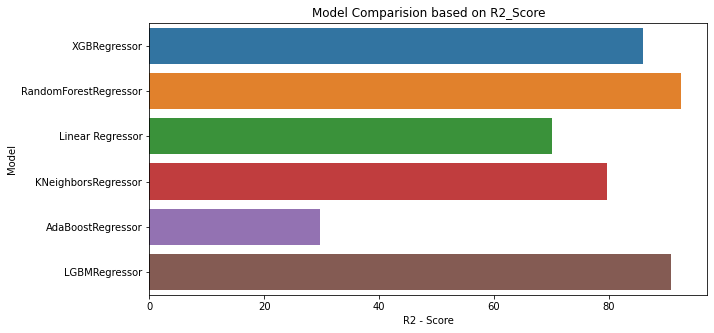

In [173]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "R2 - Score" , data = score)
plt.title("Model Comparision based on R2_Score");

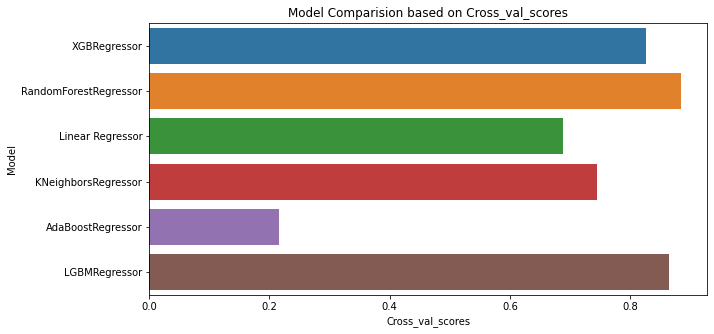

In [174]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "Cross_val_scores" , data = score)
plt.title("Model Comparision based on Cross_val_scores");

We can clearly see that Random Forest Regressor is winning

In [175]:
random_search_testing_scores = []

##Lets find the best parameter for RFC and tune it with hyperparameters using RandomSearch


In [176]:
param_dist = {
'n_estimators': list(range(10, 300, 5)),
'min_samples_leaf': list(range(1, 50)),
'max_depth': list(range(2, 30)),
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]
}

In [177]:
rfc = RandomForestRegressor()
random_search = RandomizedSearchCV(rfc, param_distributions = param_dist, n_iter = 10, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 5)

In [178]:
random_search.fit(x_train , y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=12, n_estimators=10;, score=0.791 total time=   0.1s
[CV 2/5] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=12, n_estimators=10;, score=0.737 total time=   0.1s
[CV 3/5] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=12, n_estimators=10;, score=0.726 total time=   0.1s
[CV 4/5] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=12, n_estimators=10;, score=0.724 total time=   0.1s
[CV 5/5] END bootstrap=True, max_depth=26, max_features=sqrt, min_samples_leaf=12, n_estimators=10;, score=0.779 total time=   0.1s
[CV 1/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=26, n_estimators=295;, score=0.734 total time=   0.9s
[CV 2/5] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=26, n_estimators=295;, score=0.631 total time=   0.9s
[CV 3/5] END bo

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
             

In [179]:
random_search.best_estimator_

RandomForestRegressor(max_depth=17, min_samples_leaf=15, n_estimators=45)

In [180]:
random_search.best_params_

{'bootstrap': True,
 'max_depth': 17,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'n_estimators': 45}

Testing accuracy from RandomForestRegressor

In [181]:
preds = random_search.predict(x_test)
testing_score = max(0 , 100 * r2_score(y_test , preds))
print(f"The testing score by applying tuned RandomForestRegressor is : {testing_score:.4f}")
random_search_testing_scores.append(testing_score)

The testing score by applying tuned RandomForestRegressor is : 89.4163


##Lets find the best parameter for LightGBM and tune it with hyperparameters using RandomSearch

In [182]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ,9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [183]:
lgb = lgbm.LGBMRegressor()
random_search = RandomizedSearchCV(lgb, param_distributions = params, n_iter = 8, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 3)

In [184]:
random_search.fit(x_train , y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3;, score=0.883 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3;, score=0.826 total time=   0.1s
[CV 3/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3;, score=0.829 total time=   0.1s
[CV 4/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3;, score=0.823 total time=   0.1s
[CV 5/5] END colsample_bytree=0.7, gamma=0.0, learning_rate=0.3, max_depth=4, min_child_weight=3;, score=0.866 total time=   0.1s
[CV 1/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=4, min_child_weight=9;, score=0.870 total time=   0.1s
[CV 2/5] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=4, min_child_weight=9;, score=0.823 total time=   0.1s
[CV 3/5] END colsample_bytre

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=8, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring='r2', verbose=3)

In [185]:
random_search.best_estimator_

LGBMRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=15,
              min_child_weight=7)

In [186]:
random_search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.2,
 'learning_rate': 0.2,
 'max_depth': 15,
 'min_child_weight': 7}

Testing accuracy from LGBMRegressor

In [187]:
preds = random_search.predict(x_test)
testing_score = max(0 , 100 * r2_score(y_test , preds))
print(f"The testing score by applying tuned LGBMRegressor is : {testing_score:.4f}")
random_search_testing_scores.append(testing_score)

The testing score by applying tuned LGBMRegressor is : 91.2473


##Lets find the best parameter for LightGBM and tune it with hyperparameters using RandomSearch

In [188]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ,9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [189]:
xgb = XGBRegressor()
random_search = RandomizedSearchCV(xgb, param_distributions = params, n_iter = 8, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 3)

In [190]:
random_search.fit(x_train , y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[16:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7;, score=0.832 total time=   0.4s
[16:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7;, score=0.750 total time=   0.4s
[16:10:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=7;, score=0.737 total time=   0.4s
[16:10:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 4/5] END colsample_bytree=0.4, gamma=0

RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=8, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring='r2', verbose=3)

In [191]:
random_search.best_estimator_

XGBRegressor(colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=12,
             min_child_weight=7)

In [192]:
random_search.best_params_

{'colsample_bytree': 0.7,
 'gamma': 0.1,
 'learning_rate': 0.15,
 'max_depth': 12,
 'min_child_weight': 7}

In [193]:
preds = random_search.predict(x_test)
testing_score = max(0 , 100 * r2_score(y_test , preds))
print(f"The testing score by applying tuned XGBrRegressor is : {testing_score:.4f}")
random_search_testing_scores.append(testing_score)

The testing score by applying tuned XGBrRegressor is : 90.5560


In [194]:
final_testing_score = pd.DataFrame({'Model': ['RandomForestRegressor','LightGBM','XGBRegressor'], 'Testing score': random_search_testing_scores})
final_testing_score.style.background_gradient(high=1,axis=0)

,Model,Testing score
0,RandomForestRegressor,89.416343
1,LightGBM,91.247259
2,XGBRegressor,90.556037


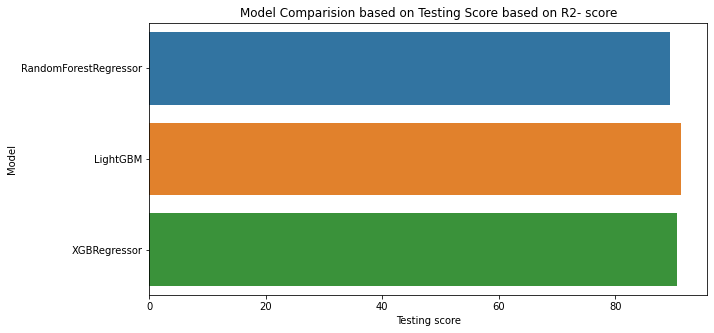

In [195]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "Testing score" , data = final_testing_score)
plt.title("Model Comparision based on Testing Score based on R2- score");

##Applying PCA on dataset

In [196]:
pca = PCA()
pca.fit(X)

PCA()

Text(0.5, 1.0, 'PCA visualisation')

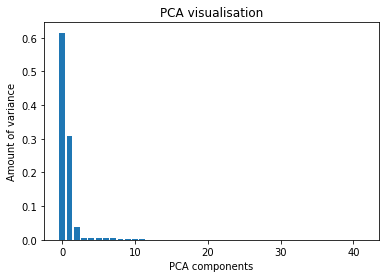

In [197]:
pca_components = list(pca.explained_variance_ratio_)
total_components = list(range(0,X.shape[1]))
plt.bar(total_components, pca_components)
plt.xlabel("PCA components")
plt.ylabel("Amount of variance")
plt.title("PCA visualisation")

From the above graph it is confirmed that first two principle components contributes to the most of variance. Hence lets see the exact value of variance which we are able to capture by taking first two PCA's.

Text(0.5, 1.0, 'PCA visualisation')

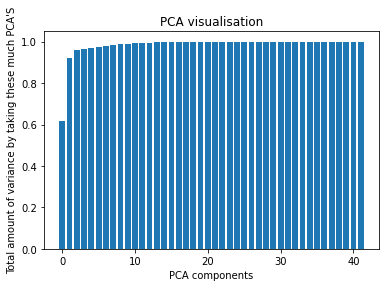

In [198]:
normalised_variance_of_pca = []
normalised_variance_of_pca.append(pca_components[0])
for i in range(1,len(pca_components)):
  normalised_variance_of_pca.append(normalised_variance_of_pca[i-1] + pca_components[i])
plt.bar(total_components, normalised_variance_of_pca)
plt.xlabel("PCA components")
plt.ylabel("Total amount of variance by taking these much PCA'S")
plt.title("PCA visualisation")

In [199]:
normalised_variance_of_pca

[0.6150931884633992,
 0.9227688920767105,
 0.9602310603666079,
 0.9663199775205772,
 0.9718328286911916,
 0.9767069146086225,
 0.9813174537856075,
 0.9853711373123951,
 0.9888217871626862,
 0.9913757581208954,
 0.9933422187477721,
 0.9950545815768501,
 0.9957948950860552,
 0.9964562357173996,
 0.9970483307270039,
 0.9975974330597096,
 0.9980586649128226,
 0.9984865292950968,
 0.998871960323814,
 0.9991757122842385,
 0.999469235721406,
 0.9996893173106719,
 0.9997920846928092,
 0.9998819541044754,
 0.9999581837461328,
 0.9999774930864805,
 0.9999838213876407,
 0.9999892320201136,
 0.9999926591950842,
 0.9999947703881308,
 0.999996084686832,
 0.999997199975419,
 0.9999979491645429,
 0.9999983931487021,
 0.9999988359567765,
 0.9999992758561559,
 0.9999996447443406,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

So from above values if we take n_components = 7 the we are able to capture about 98 % of variance.

In [201]:
values = pca.transform(X)
pca_data = pd.DataFrame(columns = ['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10'], data = values[:,:10])
pca_data['Price'] = Y
pca_data

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,Price
0,15.900540,1.238495,-0.272692,-1.115256,1.183977,-0.398289,-0.481939,-2.287862,0.593010,-0.087721,3897
1,-12.987662,13.776769,6.228482,-0.615696,-0.825967,-0.071580,1.429630,0.665934,1.616730,-0.901656,7662
2,-10.089364,20.561511,4.001122,1.172764,0.360514,1.125221,0.342327,-0.842224,-0.049587,-0.074901,13882
3,-10.324938,21.581066,-4.622670,2.188382,-0.059973,-0.618843,-1.957883,0.416767,-1.057321,-0.679356,6218
4,-5.313424,21.728380,-4.189789,-0.039976,-0.040512,-1.864152,0.589321,1.071679,1.417677,-1.006676,13302
...,...,...,...,...,...,...,...,...,...,...,...
10677,15.962536,-6.682024,0.583578,1.729765,-1.390227,-1.802866,0.293535,0.072149,-0.304018,-0.432760,4107
10678,15.971417,-6.692304,0.632804,-1.200362,-0.782271,-2.262804,-0.332652,-0.138695,-0.742683,-0.117706,4145
10679,15.883207,1.272082,-0.262852,-1.530804,-0.025908,0.538197,0.005115,-0.371797,-0.625209,0.771618,7229
10680,15.876020,1.273421,-0.334557,-0.380650,-0.894389,0.026344,0.147009,0.181443,1.981535,-0.003914,12648


In [202]:
X_pca = data.drop(columns = ['Price'], axis = 1)
Y_pca = data[['Price']]
x_train, x_test, y_train, y_test = train_test_split(X_pca,Y_pca,test_size = 0.3, random_state = 42)

In [203]:
param_dist = {
'n_estimators': list(range(10, 300, 5)),
'min_samples_leaf': list(range(1, 50)),
'max_depth': list(range(2, 30)),
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]
}

In [218]:
random_search_testing_scores_pca = []

In [204]:
rfc_pca = RandomForestRegressor()
random_search_pca_rfc = RandomizedSearchCV(rfc_pca, param_distributions = param_dist, n_iter = 10, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 5)
random_search_pca_rfc.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=14, n_estimators=145;, score=0.801 total time=   0.6s
[CV 2/5] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=14, n_estimators=145;, score=0.708 total time=   0.6s
[CV 3/5] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=14, n_estimators=145;, score=0.704 total time=   0.6s
[CV 4/5] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=14, n_estimators=145;, score=0.725 total time=   0.6s
[CV 5/5] END bootstrap=True, max_depth=17, max_features=sqrt, min_samples_leaf=14, n_estimators=145;, score=0.793 total time=   0.6s
[CV 1/5] END bootstrap=True, max_depth=18, max_features=auto, min_samples_leaf=41, n_estimators=260;, score=0.802 total time=   3.6s
[CV 2/5] END bootstrap=True, max_depth=18, max_features=auto, min_samples_leaf=41, n_estimators=260;, score=0.696 total time=   2.9s
[CV 3/5]

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
             

In [205]:
random_search_pca_rfc.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=13, min_samples_leaf=11,
                      n_estimators=135)

In [206]:
random_search_pca_rfc.best_params_

{'bootstrap': False,
 'max_depth': 13,
 'max_features': 'auto',
 'min_samples_leaf': 11,
 'n_estimators': 135}

In [219]:
preds = random_search_pca_rfc.predict(x_test)
testing_score = max(0 , 100 * r2_score(y_test , preds))
print(f"The testing score by applying tuned RandomForestRegressor is : {testing_score:.4f}")
random_search_testing_scores_pca.append(testing_score)

The testing score by applying tuned RandomForestRegressor is : 83.5193


In [208]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ,9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [209]:
lgb_pca = lgbm.LGBMRegressor()
random_search_pca_lgb = RandomizedSearchCV(lgb_pca, param_distributions = params, n_iter = 8, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 3)

In [210]:
random_search_pca_lgb.fit(x_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3;, score=0.895 total time=   0.1s
[CV 2/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3;, score=0.858 total time=   0.1s
[CV 3/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3;, score=0.859 total time=   0.1s
[CV 4/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3;, score=0.851 total time=   0.1s
[CV 5/5] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3;, score=0.881 total time=   0.1s
[CV 1/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=8, min_child_weight=7;, score=0.839 total time=   0.1s
[CV 2/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.05, max_depth=8, min_child_weight=7;, score=0.777 total time=   0.1s
[CV 3/5] END colsa

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(), n_iter=8, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring='r2', verbose=3)

In [211]:
random_search_pca_lgb.best_estimator_

LGBMRegressor(colsample_bytree=0.7, gamma=0.1, learning_rate=0.3, max_depth=10,
              min_child_weight=7)

In [220]:
preds = random_search_pca_lgb.predict(x_test)
testing_score = max(0 , 100 * r2_score(y_test , preds))
print(f"The testing score by applying tuned LgbRegressor is : {testing_score:.4f}")
random_search_testing_scores_pca.append(testing_score)

The testing score by applying tuned LgbRegressor is : 88.3098


In [213]:
params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ,9],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [214]:
xgb_pca = XGBRegressor()
random_search_pca_xgb = RandomizedSearchCV(xgb_pca, param_distributions = params, n_iter = 8, scoring = 'r2', n_jobs = 1, cv = 5, verbose = 3)

In [215]:
random_search_pca_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[16:13:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 1/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.05, max_depth=8, min_child_weight=5;, score=0.905 total time=   1.4s
[16:13:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 2/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.05, max_depth=8, min_child_weight=5;, score=0.846 total time=   1.4s
[16:13:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 3/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.05, max_depth=8, min_child_weight=5;, score=0.879 total time=   1.4s
[16:13:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV 4/5] END colsample_bytree=0.7, gamm

RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_iter=8, n_jobs=1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7, 9]},
                   scoring='r2', verbose=3)

In [221]:
preds = random_search_pca_xgb.predict(x_test)
testing_score = max(0 , 100 * r2_score(y_test , preds))
print(f"The testing score by applying tuned XgbRegressor is : {testing_score:.4f}")
random_search_testing_scores_pca.append(testing_score)

The testing score by applying tuned XgbRegressor is : 91.9097


In [222]:
final_testing_score = pd.DataFrame({'Model': ['RandomForestRegressor','LightGBM','XGBRegressor'], 'Testing score': random_search_testing_scores_pca})
final_testing_score.style.background_gradient(high=1,axis=0)

,Model,Testing score
0,RandomForestRegressor,83.519255
1,LightGBM,88.309803
2,XGBRegressor,91.909704


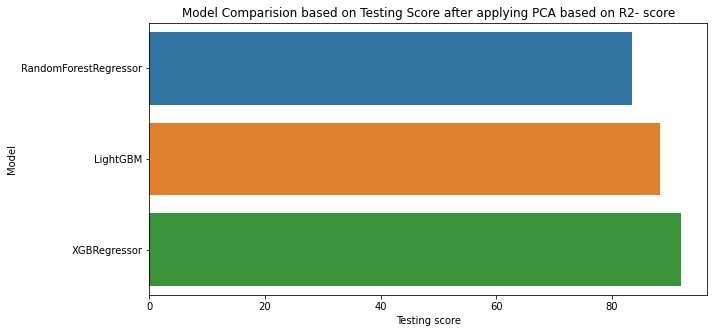

In [224]:
plt.figure(figsize = (10 , 5))
sns.barplot(y = "Model" , x = "Testing score" , data = final_testing_score)
plt.title("Model Comparision based on Testing Score after applying PCA based on R2- score");